In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.4 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
construction_types = 'suspension','beam'
path = Path('bridges')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in construction_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bridge')
        download_images(dest, urls=results)

In [ ]:
fns = get_image_files(path)
fns

(#351) [Path('bridges/suspension/54f5a470-7986-4990-814c-ffc6b48c00f6.jpg'),Path('bridges/suspension/c432e59b-4719-4292-9ca9-f6ca014522aa.JPG'),Path('bridges/suspension/eda7aa8e-b269-457c-832e-704d9b87e615.jpg'),Path('bridges/suspension/11f45259-98a4-4a9e-bfd1-482d2fe9bcea.jpg'),Path('bridges/suspension/a3beb2d4-e58b-480a-bf39-b782f5253e84.jpg'),Path('bridges/suspension/8c920cc9-8d32-4e93-8342-a76794890c3b.jpg'),Path('bridges/suspension/f3cf8f35-0ffe-43ee-9deb-012a55ece85b.jpg'),Path('bridges/suspension/f7cab8df-8265-4dd3-8d32-4acc00643bcd.JPG'),Path('bridges/suspension/b3784c96-2172-4819-9cbb-82833d72d954.jpg'),Path('bridges/suspension/258b0a63-9f26-49e6-abd5-a9c6dc67becc.jpg')...]

Let's check corrupted files

In [ ]:
failed = verify_images(fns)
failed

(#23) [Path('bridges/suspension/11f45259-98a4-4a9e-bfd1-482d2fe9bcea.jpg'),Path('bridges/suspension/8c920cc9-8d32-4e93-8342-a76794890c3b.jpg'),Path('bridges/suspension/44ae6a07-757a-4d27-bcf8-c4b2c0675cad.jpg'),Path('bridges/suspension/f413eaab-8cf3-436f-b9d8-06c7a8d70aaf.jpg'),Path('bridges/suspension/c392d974-43aa-43ff-ba7e-857e56f63401.JPG'),Path('bridges/suspension/d63d3663-e35f-4811-864d-21549cbef2df.jpg'),Path('bridges/suspension/3124fef1-7fec-4a19-92e6-5cb4475e1c47.jpg'),Path('bridges/suspension/7bfc7f53-6221-4db3-bb89-c4ef8fd32e23.jpg'),Path('bridges/suspension/7f1d9af9-93c4-4910-922b-2261b523dede.jpg'),Path('bridges/suspension/c021c5a3-8f7e-420e-bf5c-94caf77aa75d.jpg')...]

To remove the failed images, we can use __unlink__ on each of them.

In [ ]:
failed.map(Path.unlink)

(#23) [None,None,None,None,None,None,None,None,None,None...]

In [ ]:
bridges = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

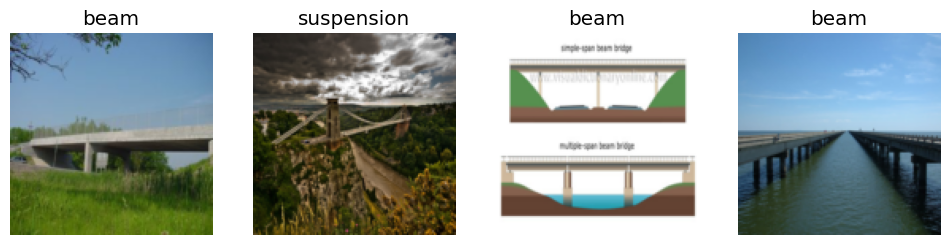

In [ ]:
bridges = bridges.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms = aug_transforms())
dls = bridges.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
learn = vision_learner(dls, resnet18, metrics = error_rate)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# To delete all images selected for deletion
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# To move inages for which we selected a different category
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)